In [1]:
import ibmos2spark
# @hidden_cell
credentials = {
    'endpoint': 'https://s3-api.us-geo.objectstorage.service.networklayer.com',
    'service_id': 'iam-ServiceId-2812a631-33ba-405c-bffd-6ef62207e620',
    'iam_service_endpoint': 'https://iam.ng.bluemix.net/oidc/token',
    'api_key': 'KyLAWfP-pxFBLI38ihleJHZol5MyZgqmFsU6Tb6-0MQ9'
}

configuration_name = 'os_e239e841f3c54322a1c2526ecf3d9ef1_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Sparkify").getOrCreate()
# Since JSON data can be semi-structured and contain additional metadata, it is possible that you might face issues with the DataFrame layout.
# Please read the documentation of 'SparkSession.read()' to learn more about the possibilities to adjust the data loading.
# PySpark documentation: http://spark.apache.org/docs/2.0.2/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.json

df = spark.read.json(cos.url('medium-sparkify-event-data.json', 'sparky-donotdelete-pr-qnxf6m436nifrd'))
df.take(5)

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20191124183125-0001
KERNEL_ID = f41a8a73-30b2-402c-babf-6001c347b1b7


[Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293'),
 Row(artist="John Brown's Body", auth='Logged In', firstName='Sawyer', gender='M', itemInSession=74, lastName='Larson', length=380.21179, level='free', location='Houston-The Woodlands-Sugar Land, TX', method='PUT', page='NextSong', registration=1538069638000, sessionId=97, song='Bulls', status=200, ts=1538352025000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='98'),
 Row(artist='Afroman', auth='Logged In', firstName='Maverick', gender='M', 

In [2]:
# import libraries
from pyspark.sql.functions import count, avg, col, concat, desc, explode, lit, min, max, split, udf, when, isnull, collect_list
from pyspark.sql.types import IntegerType, BooleanType, FloatType
from pyspark.ml.feature import VectorAssembler, StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from pyspark.ml.classification import LogisticRegression, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Exploratory Data Analysis

### Define Churn

Using the `Cancellation Confirmation` events to define my label churn, which happen for both paid and free users.

### Explore Data

In [3]:
df.columns

['artist',
 'auth',
 'firstName',
 'gender',
 'itemInSession',
 'lastName',
 'length',
 'level',
 'location',
 'method',
 'page',
 'registration',
 'sessionId',
 'song',
 'status',
 'ts',
 'userAgent',
 'userId']

In [4]:
df.count()

543705

In [5]:
df.select('auth').distinct().show()

+----------+
|      auth|
+----------+
|Logged Out|
| Cancelled|
|     Guest|
| Logged In|
+----------+



In [6]:
df.select('level').distinct().show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



In [7]:
df.select('method').distinct().show()

+------+
|method|
+------+
|   PUT|
|   GET|
+------+



In [8]:
df.select('status').distinct().show()

+------+
|status|
+------+
|   307|
|   404|
|   200|
+------+



In [9]:
df.select('page').distinct().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
| Submit Registration|
|            Settings|
|               Login|
|            Register|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
+--------------------+
only showing top 20 rows



In [10]:
# select fields
df_clean = df.select(
                    'artist',
                    'auth',
                    'gender',
                    'itemInSession',
                    'length',
                    'level',
                    'location',
                    'method',
                    'page',
                    'registration',
                    'sessionId',
                    'song',
                    'status',
                    'ts',
                    'userAgent',
                    'userId')

In [11]:
df_churn = df_clean.groupby('userId').agg(collect_list('auth').alias("auths"))
churned = udf(lambda x: 'Cancelled' in x)
df_churn = df_churn.withColumn("Churned", churned(df_churn.auths))
df_churn = df_churn.drop('auths')

In [12]:
df_label = df_churn.join(df_clean,'userId')
df_label.groupby("Churned").avg("length").collect()

[Row(Churned='false', avg(length)=248.5848635245238),
 Row(Churned='true', avg(length)=248.99398360601683)]

In [13]:
df_label.select(["userId","Churned"]).distinct().groupBy("Churned").count().collect()

[Row(Churned='false', count=350), Row(Churned='true', count=99)]

In [14]:
df_label.select(["userId","Churned"]).distinct().count()

449

Text(0.5, 1.0, 'Distribution of users')

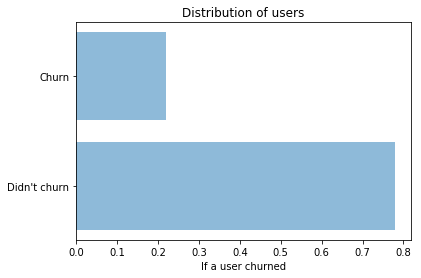

In [15]:
importances = [350/449, 99/449]
churn = ["Didn't churn", "Churn"]
y_pos = np.arange(len(churn))
 
plt.barh(y_pos, importances, align='center', alpha=0.5)
plt.yticks(y_pos, churn)
plt.xlabel('If a user churned')
plt.title('Distribution of users')

### Feature Engineering

In [16]:
songsPlayed = df_label.where(col('song')!='null').groupby("userId").agg(count(col('song'))\
                                                                        .alias('SongsPlayed')).orderBy('userId')

In [17]:
df_features = df_churn.join(songsPlayed,'userId')

In [18]:
df_features.groupby("Churned").avg("SongsPlayed").collect()

[Row(Churned='false', avg(SongsPlayed)=998.6189111747851),
 Row(Churned='true', avg(SongsPlayed)=852.1111111111111)]

In [19]:
thumbsUp = df_label.where(df_label.page=='Thumbs Up').groupby("userId").agg(count(col('page')).alias('ThumbsUp')).orderBy('userId')

In [20]:
thumbsDown = df_label.where(df_label.page=='Thumbs Down').groupby("userId").agg(count(col('page')).alias('ThumbsDown')).orderBy('userId')

In [21]:
allThumbs = thumbsUp.join(thumbsDown,'userId')

In [22]:
df_features = df_features.join(allThumbs,'userId')

In [23]:
df_features.groupby("Churned").avg("ThumbsUp").collect()

[Row(Churned='false', avg(ThumbsUp)=64.52842809364549),
 Row(Churned='true', avg(ThumbsUp)=47.8876404494382)]

In [24]:
df_features.groupby("Churned").avg("ThumbsDown").collect()

[Row(Churned='false', avg(ThumbsDown)=12.551839464882944),
 Row(Churned='true', avg(ThumbsDown)=12.98876404494382)]

In [25]:
days = df_label.groupby('userId').agg(((max(col('ts')) - min(col('ts')))/86400).alias("Days"))

In [26]:
df_features = df_features.join(days,'userId')

In [27]:
df_features.groupby("Churned").avg("Days").collect()

[Row(Churned='false', avg(Days)=49699.798556918126),
 Row(Churned='true', avg(Days)=27767.299469413225)]

In [28]:
SongAddedToPlaylist = df_label.where(col('page')!='Add to Playlist').groupby("userId").agg(count(col('page')).alias('SongAddedToPlaylist'))

In [29]:
df_features = df_features.join(SongAddedToPlaylist,'userId')

In [30]:
df_features.groupby("Churned").avg("SongAddedToPlaylist").collect()

[Row(Churned='false', avg(SongAddedToPlaylist)=1368.103678929766),
 Row(Churned='true', avg(SongAddedToPlaylist)=1127.258426966292)]

In [31]:
FreindAdded = df_label.where(col('page')!='Add Friend').groupby("userId").agg(count(col('page')).alias('FreindAdded'))

In [32]:
df_features = df_features.join(FreindAdded,'userId')

In [33]:
df_features.groupby("Churned").avg("FreindAdded").collect()

[Row(Churned='false', avg(FreindAdded)=1379.9030100334448),
 Row(Churned='true', avg(FreindAdded)=1135.3258426966293)]

In [34]:
df_features.take(1)

[Row(userId='100010', Churned='true', SongsPlayed=96, ThumbsUp=4, ThumbsDown=3, Days=3043.125, SongAddedToPlaylist=136, FreindAdded=134)]

In [35]:
# Vectorize and scale features
assembler = VectorAssembler(inputCols=["SongsPlayed", "ThumbsUp", "ThumbsDown", "Days", "SongAddedToPlaylist", "FreindAdded"], 
                            outputCol="FeatureVector")
df_features = assembler.transform(df_features)

In [36]:
scaler = StandardScaler(inputCol="FeatureVector", outputCol="ScaledFeatures", withStd=True)
scalerModel = scaler.fit(df_features)
df_features = scalerModel.transform(df_features)

In [37]:
ConvertToInt = udf(lambda x: 1 if x=="true" else 0, IntegerType())
df_features = df_features.withColumn('label', ConvertToInt(df_features.Churned))

In [38]:
df_model = df_features.select(col('label'),col('ScaledFeatures').alias('features'))
df_model.take(1)

[Row(label=1, features=DenseVector([0.0814, 0.0556, 0.2208, 0.1823, 0.0987, 0.0964]))]

In [39]:
train, test = df_model.randomSplit([0.8, 0.2], seed=50)

In [40]:
logit = LogisticRegression(maxIter=10,regParam=0.01)
gbt = GBTClassifier(maxDepth=5,maxIter=10,seed=50)

In [43]:
# logistic
el = MulticlassClassificationEvaluator(metricName='f1')
paramGrid = ParamGridBuilder().addGrid(logit.regParam,[0.01, 0.05, 0.1]).build()
crossval = CrossValidator(estimator=logit,
                          estimatorParamMaps=paramGrid,
                          evaluator=el,
                          numFolds=3)

In [44]:
cvModel_lr = crossval.fit(train)
#report the f1 score 
cvModel_lr.avgMetrics

[0.8528206824581095, 0.8334860455159201, 0.8014610015342509]

In [45]:
#gradient boosted tree models
e1 = MulticlassClassificationEvaluator(metricName='f1')
paramGrid = ParamGridBuilder().addGrid(gbt.maxDepth,[2, 5, 10]).build()
crossval = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=e1,
                          numFolds=3)

In [46]:
cvModel_boost = crossval.fit(train)
#report the f1 score 
cvModel_boost.avgMetrics

[0.8306899601055145, 0.821926676730242, 0.8173198377870556]

#### Conclusion
Among models above:

logistic regression (best f1 score 0.85)
graident boosted tree (best f1 score 0.83)

So we choose logistic regression model with tunned parameter reg=0.01).

Score on the final test set

Accuracy: 81%
F1 Score: 0.81

In [47]:
lr_best = LogisticRegression(regParam=0.01,maxIter=10)

In [48]:
lr_model = lr_best.fit(train)
results = lr_model.transform(test)

evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print(evaluator.evaluate(results, {evaluator.metricName: "accuracy"}))

0.8076923076923077


In [49]:
print(evaluator.evaluate(results, {evaluator.metricName: "f1"}))

0.8055602933651714


In [50]:
lr_model.coefficients

DenseVector([0.0787, -0.598, 0.9712, -1.6113, 0.1591, 0.1492])

Based on the coefficients, the features that contribute the most are:

1.Average number of thumbsdown song   
2.Days a user using Sparkify.

Text(0.5, 1.0, 'Logistic Regression Feature Importances')

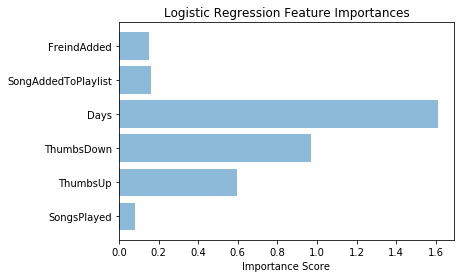

In [51]:
importances = [0.0787, 0.598, 0.9712, 1.6113, 0.1591, 0.1492]
feature = ["SongsPlayed", "ThumbsUp", "ThumbsDown", "Days", "SongAddedToPlaylist", "FreindAdded"]
y_pos = np.arange(len(feature))
 
plt.barh(y_pos, importances, align='center', alpha=0.5)
plt.yticks(y_pos, feature)
plt.xlabel('Importance Score')
plt.title('Logistic Regression Feature Importances')